In [22]:
#3D Version
from mpi4py import MPI
import gmsh
from dolfinx.io import gmsh as gmshio
from dolfinx import mesh

comm = MPI.COMM_WORLD
rank = comm.rank

x_start, y_start = 0.25, 0.01
x_end, y_end = 0.75, 0.99

# --- user params ---
h   = 0.5    # target size for Ω
h_g = 0.2   # target size for Γ

gmsh.initialize()

# ---------- Build Ω: structured quads via Gmsh ----------
n_float = 1.0 / h
n = int(round(n_float))
if abs(n_float - n) > 1e-12:
    raise ValueError("For a regular Cartesian grid, choose h = 1/n (so 1/h must be an integer).")
gmsh.model.add("Omega")

# --- Base 2D geometry (z = 0 plane) ---
p1 = gmsh.model.occ.addPoint(0, 0, 0)
p2 = gmsh.model.occ.addPoint(1, 0, 0)
p3 = gmsh.model.occ.addPoint(1, 1, 0)
p4 = gmsh.model.occ.addPoint(0, 1, 0)

l1 = gmsh.model.occ.addLine(p1, p2)
l2 = gmsh.model.occ.addLine(p2, p3)
l3 = gmsh.model.occ.addLine(p3, p4)
l4 = gmsh.model.occ.addLine(p4, p1)
cl = gmsh.model.occ.addCurveLoop([l1, l2, l3, l4])
surf = gmsh.model.occ.addPlaneSurface([cl])
gmsh.model.occ.synchronize()

# --- Structured 2D mesh controls before extrusion ---
gmsh.model.mesh.setTransfiniteCurve(l1, n + 1)
gmsh.model.mesh.setTransfiniteCurve(l2, n + 1)
gmsh.model.mesh.setTransfiniteCurve(l3, n + 1)
gmsh.model.mesh.setTransfiniteCurve(l4, n + 1)
gmsh.model.mesh.setTransfiniteSurface(surf)
gmsh.model.mesh.setRecombine(2, surf)
gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)

# --- Extrude into a thin 3D slab ---
out = gmsh.model.occ.extrude([(2, surf)], 0, 0, 0.02, numElements=[1], recombine=True)
gmsh.model.occ.synchronize()

# --- Define physical group for volume (dim=3) ---
vols = [ent[1] for ent in gmsh.model.getEntities(dim=3)]
pg_omega = gmsh.model.addPhysicalGroup(3, vols)
gmsh.model.setPhysicalName(3, pg_omega, "Omega")

# Optional: define boundary groups if needed
# walls = [ent[1] for ent in gmsh.model.getEntities(dim=2)]
# gmsh.model.addPhysicalGroup(2, walls)

# --- Generate mesh ---
gmsh.model.mesh.generate(3)
Omega, cell_tags_Omega, facet_tags_Omega = gmshio.model_to_mesh(
    gmsh.model, comm, rank, gdim=3
)[0:3]

# --- Save Ω mesh before clearing ---
if rank == 0:
    gmsh.write("Omega_tmp.msh")

# Clear gmsh model before building Γ
gmsh.clear()

# ================= Γ: line (1D embedded in 3D plane z=0) =================
gmsh.model.add("Gamma")
p0 = gmsh.model.occ.addPoint(x_start, y_start, 0.01)
p1 = gmsh.model.occ.addPoint(x_end, y_end, 0.01)
line = gmsh.model.occ.addLine(p0, p1)
gmsh.model.occ.synchronize()

gmsh.model.mesh.setSize([(0, p0), (0, p1)], h_g)
pg_gamma = gmsh.model.addPhysicalGroup(1, [line])
gmsh.model.setPhysicalName(1, pg_gamma, "Gamma")
gmsh.model.mesh.generate(1)

# Import Gamma mesh, embed in 3D (gdim=3)
Gamma, cell_tags_Gamma, facet_tags_Gamma = gmshio.model_to_mesh(gmsh.model, comm, rank, gdim=3)[0:3]

gmsh.finalize()

# --- Save the final Gmsh model to file ---
# if rank == 0:
#     gmsh.write("gamma_tmp.msh")
#     print("Gmsh model saved to nonconforming_mesh.msh")

if rank == 0:
    print("Omega:", Omega.topology.dim, "geom_dim:", Omega.geometry.dim)
    print("Gamma:", Gamma.topology.dim, "geom_dim:", Gamma.geometry.dim)


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Extruded)
Info    : [ 50%] Meshing curve 6 (Extruded)
Info    : [ 60%] Meshing curve 7 (Extruded)
Info    : [ 60%] Meshing curve 8 (Extruded)
Info    : [ 70%] Meshing curve 9 (Extruded)
Info    : [ 80%] Meshing curve 10 (Extruded)
Info    : [ 90%] Meshing curve 11 (Extruded)
Info    : [100%] Meshing curve 12 (Extruded)
Info    : Done meshing 1D (Wall 0.000570436s, CPU 0.001338s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 20%] Meshing surface 2 (Extruded)
Info    : [ 40%] Meshing surface 3 (Extruded)
Info    : [ 60%] Meshing surface 4 (Extruded)
Info    : [ 70%] Meshing surface 5 (Extruded)
Info    : [ 90%] Meshing surface 6 (Extruded)
Info    : Done meshing 2D (Wall 0.00021514s, CPU 0.000177s)
Info    : Meshing 3D...
Info    : Mes

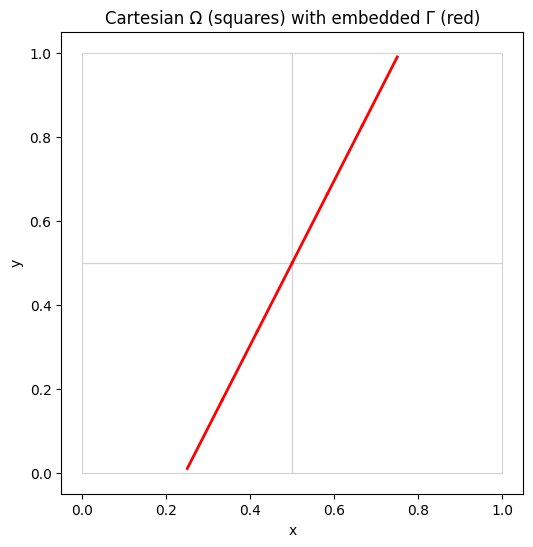

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Ω quads
xO = Omega.geometry.x
Omega.topology.create_connectivity(Omega.topology.dim, 0)
cO = Omega.topology.connectivity(Omega.topology.dim, 0)

# Γ line
xG = Gamma.geometry.x
Gamma.topology.create_connectivity(Gamma.topology.dim, 0)
cG = Gamma.topology.connectivity(Gamma.topology.dim, 0)

fig, ax = plt.subplots(figsize=(6, 6))

# --- plot Ω as proper squares (no diagonals) ---
nc = Omega.topology.index_map(Omega.topology.dim).size_local
for cell in range(nc):
    verts = cO.links(cell)
    pts = xO[verts, :2]                      # (4,2)
    ctr = pts.mean(axis=0)
    ang = np.arctan2(pts[:,1]-ctr[1], pts[:,0]-ctr[0])
    order = np.argsort(ang)                  # CCW order
    poly = np.vstack([pts[order], pts[order[0]]])
    ax.plot(poly[:,0], poly[:,1], color="lightgray", linewidth=0.8)

# --- plot Γ on top ---
ng = Gamma.topology.index_map(Gamma.topology.dim).size_local
for cell in range(ng):
    verts = cG.links(cell)
    pts = xG[verts, :2]
    ax.plot(pts[:,0], pts[:,1], color="red", linewidth=2)

ax.set_aspect("equal")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title("Cartesian Ω (squares) with embedded Γ (red)")
plt.show()


In [24]:
from dolfinx import mesh, fem
import ufl
order = 1
V_m = fem.functionspace(Omega, ("Lagrange", order))  # bulk Ω
V_f = fem.functionspace(Gamma, ("Lagrange", order))   # interface Γ
V_l = fem.functionspace(Gamma, ("Lagrange", order))   # multiplier space on Γ
W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

In [25]:
# ---------------------------------------------------------------------
# 3. Trial and Test functions
# ---------------------------------------------------------------------
phi, psi, mu = ufl.TestFunctions(W)
# dp_m, dp_f, dl = ufl.TrialFunctions(W)
p_m, p_f, lmbd = ufl.TrialFunctions(W)
# p_m = fem.Function(V_m, name="p_m")
# p_f = fem.Function(V_f, name="p_f")
# lmbd = fem.Function(V_f, name="lmbd")

# ---------------------------------------------------------------------
# 4. Spatial coordinates and given data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(Omega)
f_m = fem.Constant(Omega, 0.0)
f_f = fem.Constant(Gamma, 0.0)

# k_m = fem.Constant(Omega, 1.0)
# Diagonal entries
k_values = np.array([[1.0, 0.0, 0.0],
                     [0.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0]])

# Define as a constant tensor field over Omega
k_m = fem.Constant(Omega, k_values)
k_f = fem.Constant(Gamma, 10.0)

dx = ufl.Measure("dx", domain=Omega)
ds = ufl.Measure("dx", domain=Gamma)

In [26]:
# ---------------------------------------------------------------------
# 5. Weak formulations
# ---------------------------------------------------------------------
# --- Averaged trace operators for bulk functions on Γ (fenicsx_ii) ---
from fenicsx_ii import Average, Circle
import basix.ufl
R = 0.01        # tube/circle radius around Γ (tune as you like)
q_degree = 16   # quadrature degree along the circle (tune)

# Restriction operators for trial and test sides
restriction_trial = Circle(Gamma, R, degree=q_degree, )
restriction_test  = Circle(Gamma, R, degree=q_degree)

# Quadrature space on Γ used to represent the averages
q_el = basix.ufl.quadrature_element(Gamma.basix_cell(), value_shape=(), degree=q_degree)
Rs   = fem.functionspace(Gamma, q_el)

# Averages for the *bulk* unknown and *bulk* test, to be used only on integrals over Γ
avg_pm  = Average(p_m,  restriction_trial, Rs)  # Π_R(p_m) on Γ
avg_phi = Average(phi, restriction_test,  Rs)   # Π_R(φ)   on Γ

# --- Bulk domain Ω ---------------------------------------------------
a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
# a_m1 = -lmbd * phi * ds
a_m1 = - lmbd * avg_phi * ds
a_m = a_m0 + a_m1
L_m = f_m * phi * dx

# --- Interface Γ -----------------------------------------------------
a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
a_f1 = lmbd * psi * ds
a_f = a_f0 + a_f1
L_f = f_f * psi * ds

# --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
# a_l0 = p_m * mu * ds
a_l0 =  avg_pm * mu * ds          # <-- use averaged bulk unknown on Γ
a_l1 = -p_f * mu * ds
a_l = a_l0 + a_l1
L_l = fem.Constant(Gamma, 0.0) * mu * ds

# ---------------------------------------------------------------------
# 6. Combine interface weak form
# ---------------------------------------------------------------------
a_gamma = a_f + a_l
L_gamma = L_f + L_l

F = a_m - L_m + a_gamma - L_gamma
residual = ufl.extract_blocks(F)

# jac = ufl.derivative(F, p_m, dp_m) + ufl.derivative(F, p_f, dp_f) + ufl.derivative(F, lmbd, dl)
# J = ufl.extract_blocks(jac)

In [27]:
import numpy as np
# Compute bounding box to locate sides
coords = Omega.geometry.x
x = coords[:, 0]
y = coords[:, 1]

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# Tolerance for side detection
tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# Locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

# Union of all boundary dofs for which we enforce a value
# all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))
all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))

# Build a Function-valued BC so we can assign side-dependent values
p_m_bc = fem.Function(V_m)
# p_m_bc.x.array[:] = 1.0  # default 0 (bottom + right)
p_m_bc.x.array[left_dofs] = 1.0
p_m_bc.x.array[right_dofs]  = 4.0

# One BC object over the union of dofs with piecewise values
bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

# tolerance scaled to Γ
tol_g = 1e-10 * np.max(np.ptp(Gamma.geometry.x, axis=0))

# locate dofs at each tip
tip1_dofs = fem.locate_dofs_geometrical(
    V_f,
    lambda x: np.logical_and(np.isclose(x[0], x_start, atol=tol_g),
                             np.isclose(x[1], y_start, atol=tol_g))
)
tip2_dofs = fem.locate_dofs_geometrical(
    V_f,
    lambda x: np.logical_and(np.isclose(x[0], x_end, atol=tol_g),
                             np.isclose(x[1], y_end, atol=tol_g))
)
# OR (ii) Different values at the two tips -> two BC objects
both_tips = np.unique(np.concatenate([tip1_dofs, tip2_dofs]))

# one Function-valued BC with piecewise values
pf_fun = fem.Function(V_f)
# pf_fun.x.array[:] = 0.0
pf_fun.x.array[tip1_dofs] = 1   # e.g. 1.0
pf_fun.x.array[tip2_dofs] = 4   # e.g. 3.0

bc_pf = fem.dirichletbc(pf_fun, both_tips)

# add it
bcs = [bc_pm, bc_pf]

# print("DOFs in p_m:", p_m.function_space.dofmap.index_map.size_global)
# print("DOFs in p_f:", p_f.function_space.dofmap.index_map.size_global)
# print("DOFs in λ:", lmbd.function_space.dofmap.index_map.size_global)
# total_dofs = (
#     p_m.function_space.dofmap.index_map.size_global
#     + p_f.function_space.dofmap.index_map.size_global
#     + lmbd.function_space.dofmap.index_map.size_global
# )
# print("Total DOFs:", total_dofs)

In [28]:
a = a_m + a_gamma
L = L_m + L_gamma

In [29]:
L

Form([Integral(Product(Constant(Mesh(blocked element (Basix element (P, interval, 1, equispaced, unset, False, float64, []), (3,)), 7), (), 6), Argument(FunctionSpace(Mesh(blocked element (Basix element (P, interval, 1, equispaced, unset, False, float64, []), (3,)), 7), Basix element (P, interval, 1, gll_warped, unset, False, float64, [])), 0, 1)), 'cell', Mesh(blocked element (Basix element (P, interval, 1, equispaced, unset, False, float64, []), (3,)), 7), 'everywhere', {}, None), Integral(Product(Constant(Mesh(blocked element (Basix element (P, interval, 1, equispaced, unset, False, float64, []), (3,)), 7), (), 9), Argument(FunctionSpace(Mesh(blocked element (Basix element (P, interval, 1, equispaced, unset, False, float64, []), (3,)), 7), Basix element (P, interval, 1, gll_warped, unset, False, float64, [])), 0, 2)), 'cell', Mesh(blocked element (Basix element (P, interval, 1, equispaced, unset, False, float64, []), (3,)), 7), 'everywhere', {}, None), Integral(Product(Constant(Mesh

In [30]:
from fenicsx_ii import LinearProblem, assemble_scalar
petsc_options = {
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "ksp_error_if_not_converged": True,
}
problem = LinearProblem(
    a,
    L,
    petsc_options_prefix="coupled_poisson",
    petsc_options=petsc_options,
    bcs=bcs,
)
p_m, p_f, lmbd = problem.solve()
p_m.name = "p_m"
p_f.name = "p_f"
lmbd.name = "lmbd"

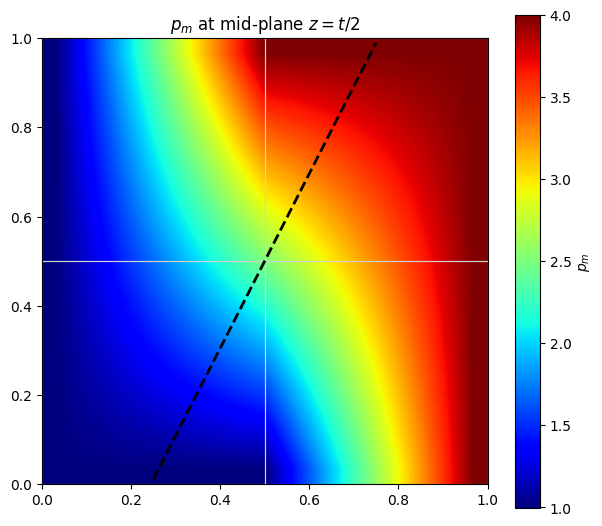

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from dolfinx import geometry

# ---- parameters for the mid-plane sampling ----
thickness = 0.02          # same value you extruded with
z_mid = 0 / 2.0   # center of the slab
nx, ny = 15, 15         # sampling resolution (tweak as you like)

# Regular grid in (x,y), z fixed at z_mid
xs = np.linspace(0.0, 1.0, nx)
ys = np.linspace(0.0, 1.0, ny)
X, Y = np.meshgrid(xs, ys, indexing="xy")
points = np.column_stack([X.ravel(), Y.ravel(), np.full(X.size, z_mid)])

# ---- find containing cells for each point (mid-plane) ----
tdim = Omega.topology.dim
bb = geometry.bb_tree(Omega, tdim)
collisions = geometry.compute_collisions_points(bb, points)
cells = geometry.compute_colliding_cells(Omega, collisions,points)

# cells is a list-of-lists; choose the first valid containing cell, else -1
cell_index = np.full(points.shape[0], -1, dtype=np.int32)

# 'cells' is an AdjacencyList: use num_nodes + links(i)
for i in range(cells.num_nodes):
    candidates = cells.links(i)
    if len(candidates) > 0:
        cell_index[i] = candidates[0]

valid = cell_index >= 0
vals = np.full(points.shape[0], np.nan, dtype=float)
if np.any(valid):
    # Evaluate p_m at valid points
    vals[valid] = p_m.eval(points[valid], cell_index[valid]).reshape(-1)

Z = vals.reshape(ys.size, xs.size)  # image grid for plotting

# ---- plot ----
fig, ax = plt.subplots(figsize=(6.2, 5.4))
im = ax.imshow(
    Z, origin="lower",
    extent=[xs.min(), xs.max(), ys.min(), ys.max()],
    interpolation="bilinear", cmap="jet", aspect="equal"
)
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.set_title(r"$p_m$ at mid-plane $z=t/2$")
fig.colorbar(im, ax=ax, label=r"$p_m$")

# --- plot Ω as proper squares (no diagonals) ---
nc = Omega.topology.index_map(Omega.topology.dim).size_local
for cell in range(nc):
    verts = cO.links(cell)
    pts = xO[verts, :2]                      # (4,2)
    ctr = pts.mean(axis=0)
    ang = np.arctan2(pts[:,1]-ctr[1], pts[:,0]-ctr[0])
    order = np.argsort(ang)                  # CCW order
    poly = np.vstack([pts[order], pts[order[0]]])
    ax.plot(poly[:,0], poly[:,1], color="lightgray", linewidth=0.8)

# overlay Γ (projected to 2D)
ax.plot([x_start, x_end], [y_start, y_end], "k--", lw=2)

plt.tight_layout()
plt.show()


In [88]:
from dolfinx import geometry
ref_points = restriction_trial.compute_quadrature(
    np.arange(Gamma.topology.index_map(Gamma.topology.dim).size_local),
    V_f.element.interpolation_points
).points

ownership = geometry.determine_point_ownership(Omega, ref_points, padding=1e-3)
assert (ownership.src_owner >= 0).all(), "Some points not found in Omega!"

In [76]:
ownership.src_owner

array([-1, -1,  0,  0,  0,  0, -1, -1, -1,  0,  0,  0], dtype=int32)

In [89]:
print("Omega bounding box:")
print(Omega.geometry.x.min(axis=0), Omega.geometry.x.max(axis=0))

print("Gamma range:")
print(Gamma.geometry.x.min(axis=0), Gamma.geometry.x.max(axis=0))


Omega bounding box:
[0. 0. 0.] [1.   1.   0.02]
Gamma range:
[0.25 0.01 0.01] [0.75 0.99 0.01]


In [90]:
from dolfinx import mesh
import numpy as np

tdim = Omega.topology.dim
Omega.topology.create_connectivity(tdim, 0)  # cells→vertices
connectivity = Omega.topology.connectivity(tdim, 0)
x = Omega.geometry.x
for cid in range(Omega.topology.index_map(tdim).size_local):
    verts = connectivity.links(cid)
    coords = x[verts]
    # print(coords)
    xmin, ymin, zmin = coords.min(axis=0)
    xmax, ymax, zmax = coords.max(axis=0)
    print(f"Cell {cid}: x[{xmin:.3f}, {xmax:.3f}], y[{ymin:.3f}, {ymax:.3f}], z[{zmin:.3f}, {zmax:.3f}]")


Cell 0: x[0.000, 0.500], y[0.000, 0.500], z[0.000, 0.020]
Cell 1: x[0.500, 1.000], y[0.000, 0.500], z[0.000, 0.020]
Cell 2: x[0.000, 0.500], y[0.500, 1.000], z[0.000, 0.020]
Cell 3: x[0.500, 1.000], y[0.500, 1.000], z[0.000, 0.020]


In [91]:
ref_points = restriction_trial.compute_quadrature(
    np.arange(Gamma.topology.index_map(Gamma.topology.dim).size_local),
    V_f.element.interpolation_points
).points

print("Γ quadrature points (flattened):")
for cid, cell_points in enumerate(ref_points):
    for qp in cell_points:
        print(f"cell {cid:02d}: ({qp[0]:.5f}, {qp[1]:.5f}, {qp[2]:.5f})")



Γ quadrature points (flattened):
cell 00: (0.25749, 0.00618, 0.01541)
cell 00: (0.25491, 0.00749, 0.01834)
cell 00: (0.24897, 0.01052, 0.01993)
cell 00: (0.24239, 0.01388, 0.01520)
cell 00: (0.24207, 0.01405, 0.00546)
cell 00: (0.24929, 0.01036, 0.00003)
cell 00: (0.25656, 0.00665, 0.00324)
cell 00: (0.25890, 0.00546, 0.00957)
cell 00: (0.25830, 0.00577, 0.01363)
cell 01: (0.34082, 0.16951, 0.01541)
cell 01: (0.33824, 0.17083, 0.01834)
cell 01: (0.33231, 0.17386, 0.01993)
cell 01: (0.32572, 0.17722, 0.01520)
cell 01: (0.32540, 0.17738, 0.00546)
cell 01: (0.33262, 0.17370, 0.00003)
cell 01: (0.33989, 0.16999, 0.00324)
cell 01: (0.34223, 0.16879, 0.00957)
cell 01: (0.34163, 0.16910, 0.01363)
cell 02: (0.34082, 0.16951, 0.01541)
cell 02: (0.33824, 0.17083, 0.01834)
cell 02: (0.33231, 0.17386, 0.01993)
cell 02: (0.32572, 0.17722, 0.01520)
cell 02: (0.32540, 0.17738, 0.00546)
cell 02: (0.33262, 0.17370, 0.00003)
cell 02: (0.33989, 0.16999, 0.00324)
cell 02: (0.34223, 0.16879, 0.00957)
cell 

In [46]:
ref_points.shape

(12, 9, 3)

In [17]:
from dolfinx.fem import petsc

nlp = petsc.NonlinearProblem(
    residual,
    u=[p_m, p_f, lmbd],
    J=J,
    bcs=bcs,
    # entity_maps=entity_maps,
    petsc_options={
        "snes_monitor": None,
        "snes_max_it": 200,  # default is 50, set your own limit
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "mat_mumps_icntl_14": 120,
        "ksp_error_if_not_converged": True,
        "snes_error_if_not_converged": True,
    },
    petsc_options_prefix="pmix_",
)
max_iterations = 25
normed_diff = 0
tol = 1e-5

nlp.solve()
iterations = nlp.solver.getIterationNumber()
print(f"Converged in {iterations} Newton iterations")

ValueError: too many values to unpack (expected 1)

In [ ]:
import ufl

def on_domain(F: ufl.Form, mesh) -> ufl.Form:
    """Keep only integrals of F that live on `mesh`."""
    dom = mesh.ufl_domain()
    return ufl.Form([I for I in F.integrals() if I.ufl_domain() == dom])

In [ ]:
from dolfinx import geometry
import numpy as np

# Outer = Ω (where we search cells), Inner = Γ (whose cells we map)
Outer = Omega
Inner = Gamma

# Geometric dimensions
gdim_out = Outer.geometry.dim
gdim_in  = Inner.geometry.dim  # may be 3 even if z=0

# Connectivity: inner cells -> vertices
Inner.topology.create_connectivity(Inner.topology.dim, 0)
conn = Inner.topology.connectivity(Inner.topology.dim, 0)

# Coordinates of inner mesh
X_in = Inner.geometry.x  # shape (n_in_vertices, gdim_in)

# Build midpoints shaped for the OUTER gdim
num_inner_cells = Inner.topology.index_map(Inner.topology.dim).size_local
midpoints = np.empty((num_inner_cells, gdim_out), dtype=X_in.dtype)

for i in range(num_inner_cells):
    verts = conn.links(i)
    # Slice to outer gdim to avoid (3,) -> (2,) broadcast errors
    midpoints[i, :] = X_in[verts, :gdim_out].mean(axis=0)

# Bounding-box tree on OUTER, collide points (midpoints) against OUTER
bbtree = geometry.bb_tree(Outer, Outer.topology.dim)
cands = geometry.compute_collisions_points(bbtree, np.ascontiguousarray(np.c_[midpoints, np.zeros((midpoints.shape[0], 1), dtype=midpoints.dtype)]))
colliding = geometry.compute_colliding_cells(Outer, cands, np.ascontiguousarray(np.c_[midpoints, np.zeros((midpoints.shape[0], 1), dtype=midpoints.dtype)]))  # AdjacencyList

# Map: for each inner cell i (on Γ), pick first containing outer cell (on Ω), or -1
gamma_to_omega = np.full(num_inner_cells, -1, dtype=np.int32)
for i in range(num_inner_cells):
    cells_i = colliding.links(i)  # access neighbors for point i
    if len(cells_i) > 0:
        gamma_to_omega[i] = cells_i[0]

# Make contiguous for PETSc
gamma_to_omega = np.ascontiguousarray(gamma_to_omega, dtype=np.int32)

# 2) Build the C++ EntityMap and wrap it
from dolfinx import mesh as dmesh
from dolfinx.cpp.mesh import EntityMap as CppEntityMap

# gamma_to_omega: array of length (# local Γ cells), value = containing Ω cell index
dim_sub = Gamma.topology.dim                        # 1 for a line mesh
n_local = Gamma.topology.index_map(dim_sub).size_local

# sanity checks
assert gamma_to_omega.shape == (n_local,), (
    f"Map length {gamma_to_omega.shape[0]} != #Gamma cells {n_local}"
)
if (gamma_to_omega < 0).any():
    raise ValueError("gamma_to_omega contains -1 (Γ cell outside Ω). Fix mapping first.")

gamma_to_omega = np.ascontiguousarray(gamma_to_omega, dtype=np.int32)

# NOTE: order is (Omega, Gamma, dim_sub, map)
cpp_emap = CppEntityMap(Omega.topology._cpp_object, Gamma.topology._cpp_object, dim_sub, gamma_to_omega)
gamma_to_omega_map = dmesh.EntityMap(cpp_emap)

# 3) Pass the proper object, not the numpy array
entity_maps = [gamma_to_omega_map]

# entity_maps = [gamma_to_omega]
